In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA

In [3]:
# Check PyTorch and set device accordingly (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("PyTorch is running on", device)

PyTorch is running on cpu


### ANN architecture and other general functions

In [4]:
class ANN(nn.Module):
    def __init__(self, num_feature, num_class):
        super(ANN, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_out = nn.Linear(128, num_class) 
        
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [5]:
# Check nr of parameters
model = ANN(80, 6)
params = sum([np.prod(p.size()) for p in model.parameters()])
params

55174

In [6]:
# ========== create dataset class ==========
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [7]:
# function to compute accuracy
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [8]:
# function to get class distribution
def get_class_distribution(obj, labels, idx2class):
    count_dict = {label:0 for label in labels}
    for i in obj:
        count_dict[idx2class[i]] += 1
    return count_dict

### Read data

In [9]:
# read data from csv
df = pd.read_csv("data.csv")
df.head()

,Avgaccx,Avgaccy,Avgaccz,AvgSVM,Stdaccx,Stdaccy,Stdaccz,StdSVM,Entaccx,Entaccy,...,Adf3z,meandfz,APSDz,speed,ele,data_type,person_age,person_id,sensor_id,activitylabel
0,-0.303753,7.432372,-3.781712,12.190383,3.269082,7.101847,5.986451,4.146244,11.322538,6.914159,...,20.316009,2.333336,35.994717,0.387425,0.760064,real,old,1,1,Walking upstairs
1,-0.406141,6.942041,-3.964706,12.079694,3.450044,7.444587,5.836912,4.327157,9.536997,7.061920,...,19.458823,2.833336,35.789577,0.718727,0.817485,real,old,1,1,Walking upstairs
2,-0.370697,6.429724,-4.196715,10.933430,3.130854,6.670531,4.933708,4.192900,9.161536,6.916139,...,18.516719,1.500001,34.332629,1.052226,0.416856,real,old,1,1,Walking upstairs
3,-0.528001,6.659298,-4.899464,11.503312,3.409928,6.704678,5.035308,4.194620,9.500888,6.814718,...,19.061974,1.500001,34.554294,1.146483,0.048929,real,old,1,1,Walking upstairs
4,-0.638545,6.954452,-4.775402,12.613509,3.664202,7.802148,5.628932,4.192455,8.993569,7.056684,...,19.052737,1.333335,35.465462,0.924365,-0.849368,real,old,1,1,Walking upstairs


In [10]:
# Get column names
col_features = list(df.columns[0:80])
col_metadata = list(df.columns[80:84])
col_label = df.columns[84]

<AxesSubplot:xlabel='activitylabel', ylabel='count'>

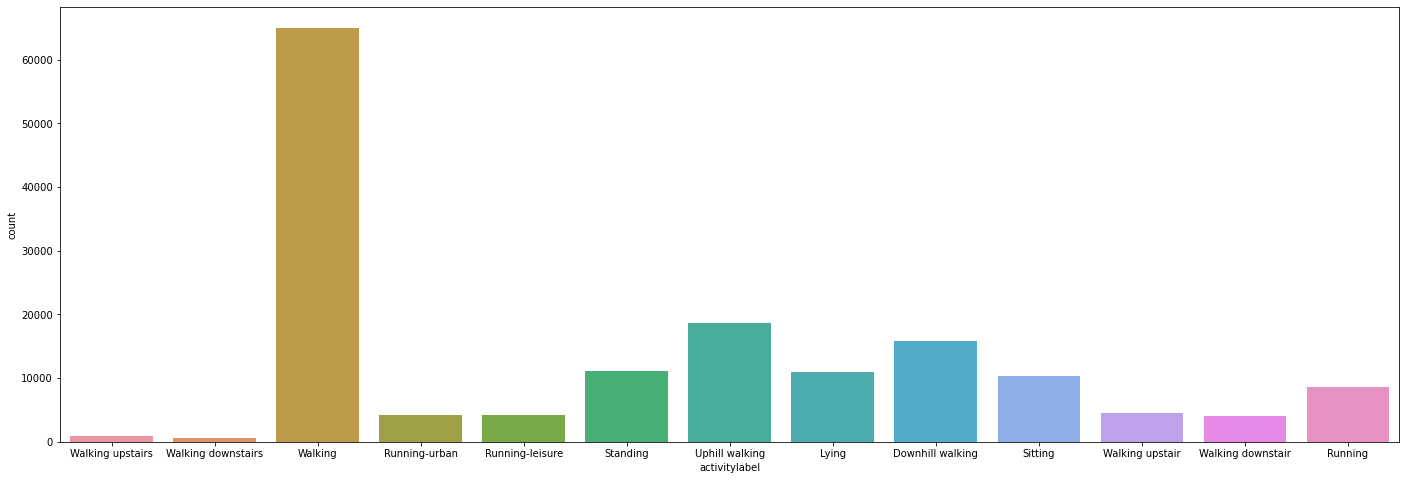

In [11]:
# Visualize labels distribution
a4_dims = (24, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(x = col_label, data=df)

<AxesSubplot:xlabel='activitylabel', ylabel='count'>

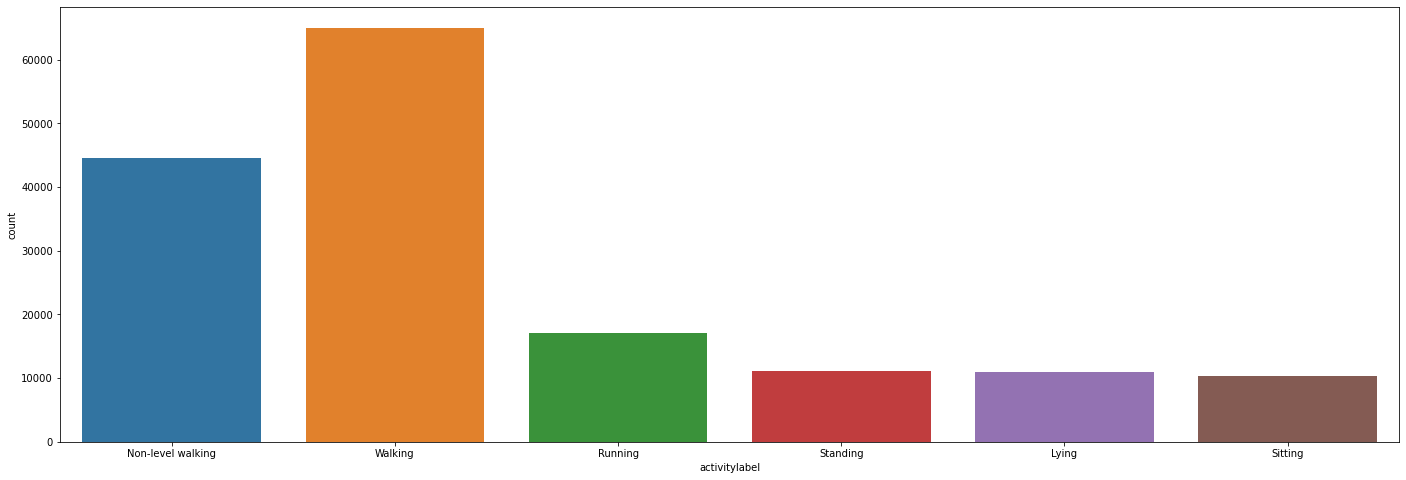

In [12]:
# Combine some labels for consistency
df.loc[df[col_label] == "Walking upstair", col_label] = "Non-level walking"
df.loc[df[col_label] == "Walking upstairs", col_label] = "Non-level walking"
df.loc[df[col_label] == "Walking downstair", col_label] = "Non-level walking"
df.loc[df[col_label] == "Walking downstairs", col_label] = "Non-level walking"
df.loc[df[col_label] == "Uphill walking", col_label] = "Non-level walking"
df.loc[df[col_label] == "Downhill walking", col_label] = "Non-level walking"

df.loc[df[col_label] == "Running-urban", col_label] = "Running"
df.loc[df[col_label] == "Running-leisure", col_label] = "Running"

# View changes
a4_dims = (24, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(x = col_label, data=df)

Stacked bar chart of PA types of each participant

In [64]:
# count PA labels time of younger adults
# df.to_csv("data_merged.csv")
df_old = df[['data_type', 'person_age', 'person_id', 'activitylabel']][df['person_age']=='old']
df_old_label = df_old.groupby(['person_id', 'activitylabel']).count()
df_old_label['hours'] = (df_old_label['data_type']+1)/3600
df_old_label_pivot = pd.pivot_table(data=df_old_label, index=['person_id'], columns=['activitylabel'], values='hours')
df_old_label_pivot = df_old_label_pivot[['Running', 'Walking', 'Non-level walking', 'Standing', 'Sitting', 'Lying']]

df_old_label_pivot['sum'] = df_old_label_pivot.sum(axis = 1)
df_old_label_pivot['Running'] = (df_old_label_pivot['Running']/df_old_label_pivot['sum'])
df_old_label_pivot['Walking'] = (df_old_label_pivot['Walking']/df_old_label_pivot['sum'])
df_old_label_pivot['Non-level walking'] = (df_old_label_pivot['Non-level walking']/df_old_label_pivot['sum'])
df_old_label_pivot['Standing'] = (df_old_label_pivot['Standing']/df_old_label_pivot['sum'])
df_old_label_pivot['Sitting'] = (df_old_label_pivot['Sitting']/df_old_label_pivot['sum'])
df_old_label_pivot['Lying'] = (df_old_label_pivot['Lying']/df_old_label_pivot['sum'])

df_old_label_pivot.pop('sum')

df_old_label_pivot

activitylabel,Running,Walking,Non-level walking,Standing,Sitting,Lying
person_id,,,,,,
1,0.104532,0.477444,0.226086,0.073204,0.047932,0.070802
2,0.092690,0.501349,0.228206,0.051508,0.064414,0.061833
3,0.107998,0.467733,0.270270,0.046332,0.049531,0.058136
4,0.098384,0.422980,0.291682,0.070377,0.050987,0.065589
5,0.117430,0.421031,0.257229,0.075150,0.071331,0.057829
6,0.098077,0.452335,0.233791,0.090797,0.061126,0.063874
7,0.089428,0.477976,0.229256,0.069965,0.074985,0.058390
8,0.109522,0.416491,0.273594,0.064367,0.067172,0.068854
9,0.116671,0.463832,0.233601,0.063391,0.057298,0.065206


In [59]:
# count PA labels time of younger adults
df_young = df[['data_type', 'person_age', 'person_id', 'activitylabel']][df['person_age']=='young']
df_young_label = df_young.groupby(['person_id', 'activitylabel']).count()
df_young_label['hours'] = (df_young_label['data_type']+1)/3600
df_young_label_pivot = pd.pivot_table(data=df_young_label, index=['person_id'], columns=['activitylabel'], values='hours')
df_young_label_pivot = df_young_label_pivot[['Running', 'Walking', 'Non-level walking', 'Standing', 'Sitting', 'Lying']]

df_young_label_pivot['sum'] = df_young_label_pivot.sum(axis = 1)
df_young_label_pivot['Running'] = (df_young_label_pivot['Running']/df_young_label_pivot['sum'])
df_young_label_pivot['Walking'] = (df_young_label_pivot['Walking']/df_young_label_pivot['sum'])
df_young_label_pivot['Non-level walking'] = (df_young_label_pivot['Non-level walking']/df_young_label_pivot['sum'])
df_young_label_pivot['Standing'] = (df_young_label_pivot['Standing']/df_young_label_pivot['sum'])
df_young_label_pivot['Sitting'] = (df_young_label_pivot['Sitting']/df_young_label_pivot['sum'])
df_young_label_pivot['Lying'] = (df_young_label_pivot['Lying']/df_young_label_pivot['sum'])

df_young_label_pivot.pop('sum')

df_young_label_pivot

activitylabel,Running,Walking,Non-level walking,Standing,Sitting,Lying
person_id,,,,,,
1,0.106824,0.335964,0.312582,0.068391,0.082712,0.093526
2,0.113228,0.336669,0.318100,0.080068,0.074521,0.077415
3,0.105605,0.331749,0.402056,0.053045,0.047227,0.060318
4,0.117393,0.388631,0.276182,0.061322,0.075224,0.081248
5,0.124526,0.321154,0.362092,0.051326,0.062935,0.077967
6,0.103257,0.384149,0.263352,0.088092,0.069366,0.091784
7,0.096109,0.386288,0.320568,0.057937,0.080049,0.059049
8,0.117672,0.351171,0.276224,0.127040,0.055926,0.071966
9,0.137950,0.375282,0.256194,0.070524,0.087979,0.072072


C:\Users\leyix\AppData\Local\Temp\ipykernel_17344\36980283.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  old.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\leyix\AppData\Local\Temp\ipykernel_17344\36980283.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis = 'y', color = 'grey', linestyle = 'dashed', linewidth = 0.5)


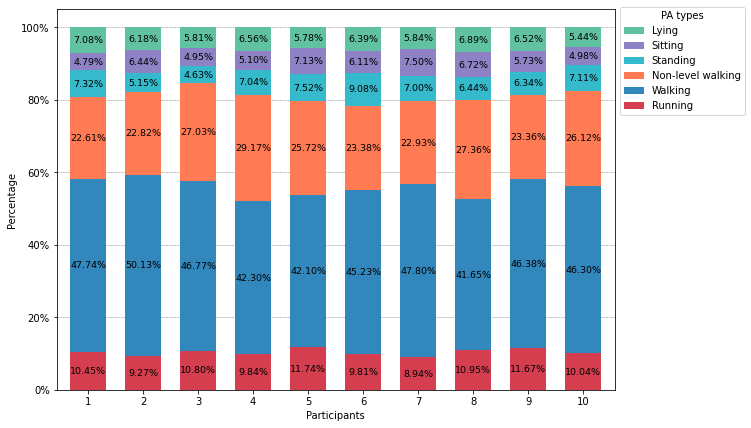

In [78]:
# plot stacked bar chart
color = ["#d53e4f", "#3288bd", "#ff7b53", "#34bacb", "#8e82c5", "#61c1a3"]
old = df_old_label_pivot.plot.bar(stacked=True, width=0.65,color=color, figsize=(10,7))
plt.xlabel("Participants")
plt.ylabel("Percentage")
old.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
old.set_xticklabels(['1','2','3','4','5','6','7','8','9','10'], rotation=0)
handles, labels = plt.gca().get_legend_handles_labels()
order = [5,4,3,2,1,0]
old.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='PA types', bbox_to_anchor=(1, 1.02), loc='upper left')
old.set_axisbelow(True)
plt.grid(b=True, axis = 'y', color = 'grey', linestyle = 'dashed', linewidth = 0.5)

for p in old.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    old.text(x+width/2, 
            y+height/2, 
            '{:.2%}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='black',
            size=9.5)

C:\Users\leyix\AppData\Local\Temp\ipykernel_17344\2217627157.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  young.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\leyix\AppData\Local\Temp\ipykernel_17344\2217627157.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis = 'y', color = 'grey', linestyle = 'dashed', linewidth = 0.5)


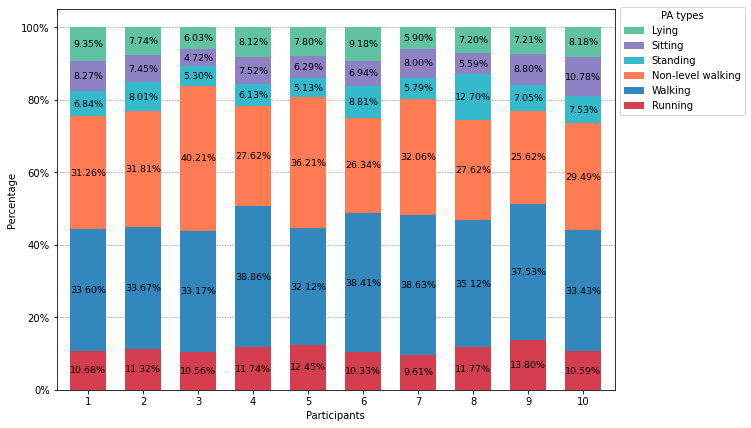

In [77]:
# plot stacked bar chart
color = ["#d53e4f", "#3288bd", "#ff7b53", "#34bacb", "#8e82c5", "#61c1a3"]
young = df_young_label_pivot.plot.bar(stacked=True, width=0.65,color=color, figsize=(10,7))
plt.xlabel("Participants")
plt.ylabel("Percentage")
young.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
young.set_xticklabels(['1','2','3','4','5','6','7','8','9','10'], rotation=0)
handles, labels = plt.gca().get_legend_handles_labels()
order = [5,4,3,2,1,0]
young.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='PA types', bbox_to_anchor=(1, 1.02), loc='upper left')
young.set_axisbelow(True)
plt.grid(b=True, axis = 'y', color = 'grey', linestyle = 'dashed', linewidth = 0.5)

for p in young.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    young.text(x+width/2, 
            y+height/2, 
            '{:.2%}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='black',
            size=9.5)


In [12]:
# =====================================================
# ================== Preprocess data ==================
# =====================================================
# scale features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[col_features])
scaled_df = pd.DataFrame(scaled, columns=col_features)
# copy metadata and labels from unscaled dataframe
for col in col_metadata:
    scaled_df[col] = list(df[col])
scaled_df[col_label] = list(df[col_label])
scaled_df.head()
df_full = scaled_df

# encode labels
labels_full = df_full[col_label].unique()

# create encoding dictionaries
class2idx = {elem: idx for (idx, elem) in enumerate(labels_full)}
idx2class = {v: k for k, v in class2idx.items()}
df_full[col_label].replace(class2idx, inplace=True)

# show new dataframe
df_full.head()

,Avgaccx,Avgaccy,Avgaccz,AvgSVM,Stdaccx,Stdaccy,Stdaccz,StdSVM,Entaccx,Entaccy,...,Adf3z,meandfz,APSDz,speed,ele,data_type,person_age,person_id,sensor_id,activitylabel
0,0.479156,0.786340,0.347873,0.203072,0.240925,0.432716,0.414227,0.420654,0.999982,0.821833,...,0.881799,0.137662,0.858917,0.069012,0.562001,real,old,1,1,0
1,0.473937,0.761727,0.339709,0.196802,0.254297,0.453617,0.403865,0.439041,0.999980,0.822932,...,0.857247,0.168831,0.855785,0.128027,0.565725,real,old,1,1,0
2,0.475744,0.736010,0.329358,0.131871,0.230711,0.406413,0.341277,0.425396,0.999980,0.821848,...,0.830264,0.085714,0.833536,0.187434,0.539743,real,old,1,1,0
3,0.467725,0.747534,0.298004,0.164152,0.251332,0.408496,0.348318,0.425571,0.999980,0.821093,...,0.845881,0.085714,0.836921,0.204224,0.515881,real,old,1,1,0
4,0.462091,0.762350,0.303539,0.227041,0.270121,0.475422,0.389453,0.425351,0.999980,0.822893,...,0.845616,0.075325,0.850835,0.164658,0.457622,real,old,1,1,0


### Scenario 1 -- Young only

In [47]:
# ====================== TRAIN models ======================
all_loss_stats_young = []
all_acc_stats_young = []
all_test_conf_mat_young = []
all_test_acc_young = []
all_test_precision_young = []
all_test_recall_young = []
all_test_f1_young = []


# Performs L1SO training for each person
for id_excluded in range(1, 11):
    # ======================================================
    # ======== Split data into train - val - test ==========
    # ======================================================
    PCA_REDUCTION = False
    K_BEST_REDUCTION = 50
    # ======================================================
    # ======================================================

    X_full = df_full.loc[:, col_features]
    y_full = df_full.loc[:, col_label]

    # get train and test ids based on the excluded persons
    ids_train = list(set(df_full.index[df_full['person_id'] != id_excluded]).intersection(set(df_full.index[df_full['person_age'] == "young"])))
    ids_test = list(set(df_full.index[df_full['person_id'] == id_excluded]).intersection(set(df_full.index[df_full['person_age'] == "old"])))

    # get train and test data
    if (PCA_REDUCTION):
        pca = PCA(n_components=0.99)
        X_full_transformed = pca.fit_transform(X_full)
        num_features = X_full_transformed.shape[1]
#         print(f'PCA kept {num_features} features out of a total of {X_full.shape[1]}.')
        X_young_train = X_full_transformed[ids_train, :]
        X_young_test = X_full_transformed[ids_test, :]
        
    elif (K_BEST_REDUCTION is not False):
        kbest = SelectKBest(score_func=chi2, k=K_BEST_REDUCTION)
        kbest_fit = kbest.fit(X_full, y_full)
        
        X_full_transformed = kbest_fit.transform(X_full)
        num_features = X_full_transformed.shape[1]
#         print(f'K-Best kept {num_features} features out of a total of {X_full.shape[1]}.')
        X_young_train = X_full_transformed[ids_train, :]
        X_young_test = X_full_transformed[ids_test, :]
        
    else:
        num_features = X_full.shape[1]
        X_young_train = X_full.iloc[ids_train, :]
        X_young_test = X_full.iloc[ids_test, :]

    y_young_train = y_full.iloc[ids_train]
    y_young_test = y_full.iloc[ids_test]

    # further split train data into train and val
    X_young_train, X_young_val, y_young_train, y_young_val = \
        train_test_split(X_young_train, y_young_train, test_size=0.1, stratify=y_young_train, random_state=42)

    # transform all to numpy arrays
    X_young_train, y_young_train = np.array(X_young_train), np.array(y_young_train)
    X_young_val, y_young_val = np.array(X_young_val), np.array(y_young_val)
    X_young_test, y_young_test = np.array(X_young_test), np.array(y_young_test)

    # show the length of each partition
    # print(f"L1SO #{id_excluded} -- train: {X_young_train.shape[0]} | val: {X_young_val.shape[0]} | test: {X_young_test.shape[0]}")

    # =====================================================
    # ========= create dataset for classification =========
    # =====================================================
    train_dataset = ClassifierDataset(torch.from_numpy(X_young_train).float(), torch.from_numpy(y_young_train).long())
    val_dataset = ClassifierDataset(torch.from_numpy(X_young_val).float(), torch.from_numpy(y_young_val).long())
    test_dataset = ClassifierDataset(torch.from_numpy(X_young_test).float(), torch.from_numpy(y_young_test).long())

    # ======================================================
    # ============ initialize weighted sampling ============
    # ======================================================
    target_list = []
    for _, t in train_dataset:
        target_list.append(t)

    target_list = torch.tensor(target_list)

    class_count = [i for i in get_class_distribution(y_young_train, labels_full, idx2class).values()]
    class_weights = 1. / torch.tensor(class_count, dtype=torch.float) 

    class_weights_all = class_weights[target_list]

    weighted_sampler = WeightedRandomSampler(
        weights=class_weights_all,
        num_samples=len(class_weights_all),
        replacement=True
    )

    # ====================================================
    # ============== Define Hyperparameters ==============
    # ====================================================
    EPOCHS = 150
    BATCH_SIZE = 512
    LEARNING_RATE = 0.0003
    NUM_FEATURES = num_features
    NUM_CLASSES = len(labels_full)

    # ====================================================
    # ================ Create dataloaders ================
    # ====================================================
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              sampler=weighted_sampler
    )
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    # ====================================================
    # ============ Define model and optimizer ============
    # ====================================================
    model_young = ANN(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
    model_young.to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.AdamW(model_young.parameters(), lr=LEARNING_RATE)

    # ============================================================
    # ==== Dictionaries to store history of accuracy and loss ====
    # ============================================================
    accuracy_stats_young = {
        'train': [],
        "val": []
    }
    loss_stats_young = {
        'train': [],
        "val": []
    }

    # ====================================================
    # ================= Train the model ==================
    # ====================================================
    # print("Begin training.")
    for e in tqdm(range(1, EPOCHS+1)):
        # TRAIN    
        train_epoch_loss = 0
        train_epoch_acc = 0

        model_young.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()

            y_train_pred = model_young(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()


        # VALIDATION    
        with torch.no_grad():
            val_epoch_loss = 0
            val_epoch_acc = 0

            model_young.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                y_val_pred = model_young(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        loss_stats_young['train'].append(train_epoch_loss/len(train_loader))
        loss_stats_young['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats_young['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats_young['val'].append(val_epoch_acc/len(val_loader))


    #     print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

    # Get final accuracy and loss
    final_loss_train = loss_stats_young['train'][-1]
    final_loss_val = loss_stats_young['val'][-1]
    final_acc_train = accuracy_stats_young['train'][-1]
    final_acc_val = accuracy_stats_young['val'][-1]
    
    all_loss_stats_young.append(loss_stats_young)
    all_acc_stats_young.append(accuracy_stats_young)

    # =================================================
    # ================== Test model ===================
    # =================================================
    y_pred_list = []
    with torch.no_grad():
        model_young.eval()
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model_young(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    # =================================================
    # ====== Confusion matrix and other metrics =======
    # =================================================
    all_test_conf_mat_young.append(confusion_matrix(y_young_test, y_pred_list))

    test_acc_young = accuracy_score(y_young_test, y_pred_list)
    all_test_acc_young.append(test_acc_young)
    test_precision_young, test_recall_young, test_fscore_young, _ = \
        precision_recall_fscore_support(y_young_test, y_pred_list, zero_division=0)
    
    all_test_precision_young.append(test_precision_young)
    all_test_recall_young.append(test_recall_young)
    all_test_f1_young.append(test_fscore_young)
    
    print(f'L1SO #{id_excluded} -- Train Loss: {final_loss_train:.5f} | Val Loss: {final_loss_val:.5f} | Train Acc: {final_acc_train:.2f}% | Val Acc: {final_acc_val:.2f}% | Test Acc: {test_acc_young*100:.2f}%')
    
    # Save model on disk
    torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model_young.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': final_loss_train,
            }, f'models/young/checkpoints/l1so_{id_excluded}.ckpt')
    

# =================================================
# ===== Save models stats and metrics on disk =====
# =================================================
model_stats_young = {"epoch_loss": all_loss_stats_young,
                    "epoch_acc": all_acc_stats_young,
                    "predictions": y_pred_list,
                    "conf_mat": all_test_conf_mat_young,
                    "test_acc": all_test_acc_young,
                    "test_precision": all_test_precision_young,
                    "test_recall": all_test_recall_young,
                    "test_f1": all_test_f1_young}

with open('models/young/stats_model.pickle', 'wb') as handle:
    pickle.dump(model_stats_young, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [15:42<00:00,  6.28s/it]


L1SO #1 -- Train Loss: 0.07280 | Val Loss: 0.20481 | Train Acc: 95.65% | Val Acc: 93.04% | Test Acc: 59.05%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [15:04<00:00,  6.03s/it]


L1SO #2 -- Train Loss: 0.08119 | Val Loss: 0.20682 | Train Acc: 95.34% | Val Acc: 92.69% | Test Acc: 60.14%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [14:09<00:00,  5.66s/it]


L1SO #3 -- Train Loss: 0.08262 | Val Loss: 0.22687 | Train Acc: 95.33% | Val Acc: 91.74% | Test Acc: 58.97%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [15:06<00:00,  6.04s/it]


L1SO #4 -- Train Loss: 0.07256 | Val Loss: 0.23674 | Train Acc: 95.50% | Val Acc: 91.90% | Test Acc: 66.80%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [14:35<00:00,  5.84s/it]


L1SO #5 -- Train Loss: 0.07374 | Val Loss: 0.24353 | Train Acc: 95.61% | Val Acc: 91.34% | Test Acc: 48.51%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [14:47<00:00,  5.92s/it]


L1SO #6 -- Train Loss: 0.07072 | Val Loss: 0.21869 | Train Acc: 95.89% | Val Acc: 92.64% | Test Acc: 47.79%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [14:41<00:00,  5.88s/it]


L1SO #7 -- Train Loss: 0.07332 | Val Loss: 0.20215 | Train Acc: 95.76% | Val Acc: 92.97% | Test Acc: 52.35%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [14:48<00:00,  5.92s/it]


L1SO #8 -- Train Loss: 0.06435 | Val Loss: 0.25757 | Train Acc: 95.91% | Val Acc: 91.10% | Test Acc: 61.09%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [14:43<00:00,  5.89s/it]


L1SO #9 -- Train Loss: 0.07779 | Val Loss: 0.23536 | Train Acc: 95.37% | Val Acc: 91.46% | Test Acc: 66.01%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [14:59<00:00,  6.00s/it]


L1SO #10 -- Train Loss: 0.06942 | Val Loss: 0.20204 | Train Acc: 96.05% | Val Acc: 93.45% | Test Acc: 55.82%


In [48]:
# ==========================================================
# ======= Load dictionary with stats about the model =======
# ==========================================================
with open('models/young/stats_model.pickle', 'rb') as handle:
    model_stats_young = pickle.load(handle)

Text(0.5, 1.0, 'Average Train-Val Loss (per Epoch)')

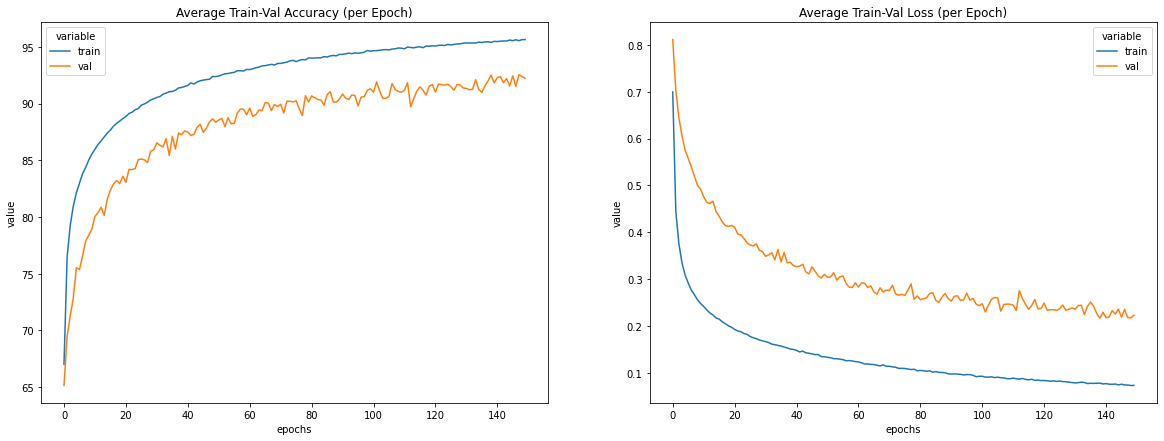

In [49]:
# ===========================================================
# ====== Visualize loss and accuracy for train and val ======
# ===========================================================
# Get mean accuracy
avg_accuracy_train = [np.mean([d['train'][idx] for d in model_stats_young['epoch_acc']]) for idx in range(len(model_stats_young['epoch_acc'][0]['train']))]
avg_accuracy_val = [np.mean([d['val'][idx] for d in model_stats_young['epoch_acc']]) for idx in range(len(model_stats_young['epoch_acc'][0]['val']))]
accuracy_stats_young = {"train": avg_accuracy_train,
                       "val": avg_accuracy_val}

# Get mean loss
avg_loss_train = [np.mean([d['train'][idx] for d in model_stats_young['epoch_loss']]) for idx in range(len(model_stats_young['epoch_loss'][0]['train']))]
avg_loss_val = [np.mean([d['val'][idx] for d in model_stats_young['epoch_loss']]) for idx in range(len(model_stats_young['epoch_loss'][0]['val']))]
loss_stats_young = {"train": avg_loss_train,
                   "val": avg_loss_val}

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_young).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_young).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Average Train-Val Accuracy (per Epoch)')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Average Train-Val Loss (per Epoch)')

In [19]:
# =======================================================
# === Show additional metrics (precision, recall, F1) ===
# =======================================================
print(f"Average accuracy: {np.mean(np.array(model_stats_young['test_acc'])) * 100:.2f}%")

avg_test_precision = np.mean(np.stack(model_stats_young['test_precision']), axis=0) * 100
avg_test_recall = np.mean(np.stack(model_stats_young['test_recall']), axis=0) * 100
avg_test_f1 = np.mean(np.stack(model_stats_young['test_f1']), axis=0) * 100

test_metrics_df_young = pd.DataFrame()
test_metrics_df_young['Label'] = labels_full
test_metrics_df_young['Precision'] = avg_test_precision
test_metrics_df_young['Precision'] = avg_test_precision
test_metrics_df_young['Recall'] = avg_test_recall
test_metrics_df_young['F1-score'] = avg_test_f1
test_metrics_df_young = test_metrics_df_young.round(decimals=2)

test_metrics_df_young

Average accuracy: 57.55%


,Label,Precision,Recall,F1-score
0,Non-level walking,39.77,71.80,50.32
1,Walking,76.95,41.27,50.36
2,Running,83.62,80.65,80.69
3,Standing,67.82,46.46,53.77
4,Lying,84.59,80.33,81.34
5,Sitting,53.95,73.57,61.23


<AxesSubplot:>

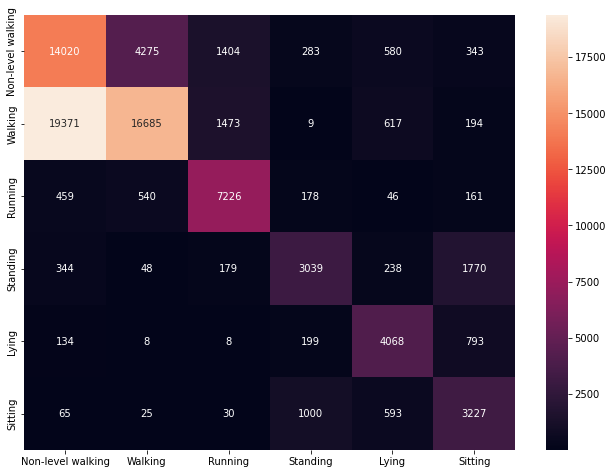

In [50]:
# =======================================================
# ======== Visualize confusion matrix (averaged) ========
# =======================================================
avg_conf_mat = np.sum(np.array(model_stats_young['conf_mat']), axis=0).astype(np.int32)
confusion_matrix_df = pd.DataFrame(avg_conf_mat).rename(columns=idx2class, index=idx2class)

a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")

### Scenario 2 -- Younger + older adults

In [14]:
# ====================== TRAIN models ======================
all_loss_stats_full = []
all_acc_stats_full = []
all_test_conf_mat_full = []
all_test_acc_full = []
all_test_precision_full = []
all_test_recall_full = []
all_test_f1_full = []


# Performs L1SO training for each person
for id_excluded in range(1, 11):
    # ======================================================
    # ======== Split data into train - val - test ==========
    # ======================================================
    PCA_REDUCTION = False
    K_BEST_REDUCTION = False
    # ======================================================
    # ======================================================

    X_full = df_full.loc[:, col_features]
    y_full = df_full.loc[:, col_label]

    # get train and test ids based on the excluded persons
    ids_train = df_full.index[df_full['person_id'] != id_excluded].tolist()
    ids_test = list(set(df_full.index[df_full['person_id'] == id_excluded]).intersection(set(df_full.index[df_full['person_age'] == "old"])))

    # get train and test data
    if (PCA_REDUCTION):
        pca = PCA(n_components=0.99)
        X_full_transformed = pca.fit_transform(X_full)
        num_features = X_full_transformed.shape[1]
        print(f'PCA kept {num_features} features out of a total of {X_full.shape[1]}.')
        X_full_train = X_full_transformed[ids_train, :]
        X_full_test = X_full_transformed[ids_test, :]
        
    elif (K_BEST_REDUCTION is not False):
        kbest = SelectKBest(score_func=chi2, k=K_BEST_REDUCTION)
        kbest_fit = kbest.fit(X_full, y_full)
        
        X_full_transformed = kbest_fit.transform(X_full)
        num_features = X_full_transformed.shape[1]
        print(f'K-Best kept {num_features} features out of a total of {X_full.shape[1]}.')
        X_full_train = X_full_transformed[ids_train, :]
        X_full_test = X_full_transformed[ids_test, :]

    else:
        num_features = X_full.shape[1]
        X_full_train = X_full.iloc[ids_train, :]
        X_full_test = X_full.iloc[ids_test, :]

    y_full_train = y_full.iloc[ids_train]
    y_full_test = y_full.iloc[ids_test]

    # further split train data into train and val
    X_full_train, X_full_val, y_full_train, y_full_val = \
        train_test_split(X_full_train, y_full_train, test_size=0.05, stratify=y_full_train, random_state=42)

    # transform all to numpy arrays
    X_full_train, y_full_train = np.array(X_full_train), np.array(y_full_train)
    X_full_val, y_full_val = np.array(X_full_val), np.array(y_full_val)
    X_full_test, y_full_test = np.array(X_full_test), np.array(y_full_test)

    # show the length of each partition
    # print(f"L1SO #{id_excluded} -- train: {X_full_train.shape[0]} | val: {X_full_val.shape[0]} | test: {X_full_test.shape[0]}")

    # =====================================================
    # ========= create dataset for classification =========
    # =====================================================
    train_dataset = ClassifierDataset(torch.from_numpy(X_full_train).float(), torch.from_numpy(y_full_train).long())
    val_dataset = ClassifierDataset(torch.from_numpy(X_full_val).float(), torch.from_numpy(y_full_val).long())
    test_dataset = ClassifierDataset(torch.from_numpy(X_full_test).float(), torch.from_numpy(y_full_test).long())

    # ======================================================
    # ============ initialize weighted sampling ============
    # ======================================================
    target_list = []
    for _, t in train_dataset:
        target_list.append(t)

    target_list = torch.tensor(target_list)

    class_count = [i for i in get_class_distribution(y_full_train, labels_full, idx2class).values()]
    class_weights = 1. / torch.tensor(class_count, dtype=torch.float) 

    class_weights_all = class_weights[target_list]

    weighted_sampler = WeightedRandomSampler(
        weights=class_weights_all,
        num_samples=len(class_weights_all),
        replacement=True
    )

    # ====================================================
    # ============== Define Hyperparameters ==============
    # ====================================================
    EPOCHS = 150
    BATCH_SIZE = 512
    LEARNING_RATE = 0.0003
    NUM_FEATURES = num_features
    NUM_CLASSES = len(labels_full)

    # ====================================================
    # ================ Create dataloaders ================
    # ====================================================
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              sampler=weighted_sampler
    )
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    # ====================================================
    # ============ Define model and optimizer ============
    # ====================================================
    model_full = ANN(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
    model_full.to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.AdamW(model_full.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    # ============================================================
    # ==== Dictionaries to store history of accuracy and loss ====
    # ============================================================
    accuracy_stats_full = {
        'train': [],
        "val": []
    }
    loss_stats_full = {
        'train': [],
        "val": []
    }

    # ====================================================
    # ================= Train the model ==================
    # ====================================================
    # print("Begin training.")
    for e in tqdm(range(1, EPOCHS+1)):
        # TRAIN    
        train_epoch_loss = 0
        train_epoch_acc = 0

        model_full.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()

            y_train_pred = model_full(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()


        # VALIDATION    
        with torch.no_grad():
            val_epoch_loss = 0
            val_epoch_acc = 0

            model_full.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                y_val_pred = model_full(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        loss_stats_full['train'].append(train_epoch_loss/len(train_loader))
        loss_stats_full['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats_full['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats_full['val'].append(val_epoch_acc/len(val_loader))
        
#         if e % 5 == 0:
#             y_pred_list = []
#             with torch.no_grad():
#                 model_full.eval()
#                 for X_batch, _ in test_loader:
#                     X_batch = X_batch.to(device)
#                     y_test_pred = model_full(X_batch)
#                     _, y_pred_tags = torch.max(y_test_pred, dim = 1)
#                     y_pred_list.append(y_pred_tags.cpu().numpy())
#             y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#             test_acc_full = accuracy_score(y_full_test, y_pred_list)
            
#             print(f'epoch {e} -- test acc: {test_acc_full}')


    #     print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

    # Get final accuracy and loss
    final_loss_train = loss_stats_full['train'][-1]
    final_loss_val = loss_stats_full['val'][-1]
    final_acc_train = accuracy_stats_full['train'][-1]
    final_acc_val = accuracy_stats_full['val'][-1]
    
    all_loss_stats_full.append(loss_stats_full)
    all_acc_stats_full.append(accuracy_stats_full)

    # =================================================
    # ================== Test model ===================
    # =================================================
    y_pred_list = []
    with torch.no_grad():
        model_full.eval()
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model_full(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    # =================================================
    # ====== Confusion matrix and other metrics =======
    # =================================================
    all_test_conf_mat_full.append(confusion_matrix(y_full_test, y_pred_list))

    test_acc_full = accuracy_score(y_full_test, y_pred_list)
    all_test_acc_full.append(test_acc_full)
    test_precision_full, test_recall_full, test_fscore_full, _ = \
        precision_recall_fscore_support(y_full_test, y_pred_list, zero_division=0)
    
    all_test_precision_full.append(test_precision_full)
    all_test_recall_full.append(test_recall_full)
    all_test_f1_full.append(test_fscore_full)
    
    print(f'L1SO #{id_excluded} -- Train Loss: {final_loss_train:.5f} | Val Loss: {final_loss_val:.5f} | Train Acc: {final_acc_train:.2f}% | Val Acc: {final_acc_val:.2f}% | Test Acc: {test_acc_full*100:.2f}%')
    
    # Save model on disk
    torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model_full.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': final_loss_train,
            }, f'models/full/checkpoints/l1so_{id_excluded}.ckpt')
    

# =================================================
# ===== Save models stats and metrics on disk =====
# =================================================
model_stats_full = {"epoch_loss": all_loss_stats_full,
                    "epoch_acc": all_acc_stats_full,
                    "predictions": y_pred_list,
                    "conf_mat": all_test_conf_mat_full,
                    "test_acc": all_test_acc_full,
                    "test_precision": all_test_precision_full,
                    "test_recall": all_test_recall_full,
                    "test_f1": all_test_f1_full}

with open('models/full/stats_model.pickle', 'wb') as handle:
    pickle.dump(model_stats_full, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [17:47<00:00,  7.12s/it]


L1SO #1 -- Train Loss: 0.01675 | Val Loss: 0.08234 | Train Acc: 98.43% | Val Acc: 97.18% | Test Acc: 73.39%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [17:56<00:00,  7.18s/it]


L1SO #2 -- Train Loss: 0.02199 | Val Loss: 0.11760 | Train Acc: 97.95% | Val Acc: 96.32% | Test Acc: 65.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [17:59<00:00,  7.20s/it]


L1SO #3 -- Train Loss: 0.01996 | Val Loss: 0.09758 | Train Acc: 98.22% | Val Acc: 97.02% | Test Acc: 62.97%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [18:13<00:00,  7.29s/it]


L1SO #4 -- Train Loss: 0.01685 | Val Loss: 0.08868 | Train Acc: 98.36% | Val Acc: 97.27% | Test Acc: 64.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [18:08<00:00,  7.26s/it]


L1SO #5 -- Train Loss: 0.01726 | Val Loss: 0.18419 | Train Acc: 98.36% | Val Acc: 93.48% | Test Acc: 68.54%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [17:58<00:00,  7.19s/it]


L1SO #6 -- Train Loss: 0.01708 | Val Loss: 0.15411 | Train Acc: 98.38% | Val Acc: 94.72% | Test Acc: 59.90%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [17:44<00:00,  7.09s/it]


L1SO #7 -- Train Loss: 0.01840 | Val Loss: 0.10740 | Train Acc: 98.26% | Val Acc: 96.29% | Test Acc: 72.37%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [18:33<00:00,  7.43s/it]


L1SO #8 -- Train Loss: 0.01711 | Val Loss: 0.11417 | Train Acc: 98.42% | Val Acc: 96.29% | Test Acc: 66.13%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [17:59<00:00,  7.20s/it]


L1SO #9 -- Train Loss: 0.01755 | Val Loss: 0.12474 | Train Acc: 98.33% | Val Acc: 95.58% | Test Acc: 72.51%


100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [18:18<00:00,  7.32s/it]


L1SO #10 -- Train Loss: 0.01601 | Val Loss: 0.09874 | Train Acc: 98.54% | Val Acc: 96.86% | Test Acc: 61.47%


##### Observe results

In [15]:
# ==========================================================
# ======= Load dictionary with stats about the model =======
# ==========================================================
with open('models/full/stats_model.pickle', 'rb') as handle:
    model_stats_full = pickle.load(handle)

Text(0.5, 1.0, 'Average Train-Val Loss (per Epoch)')

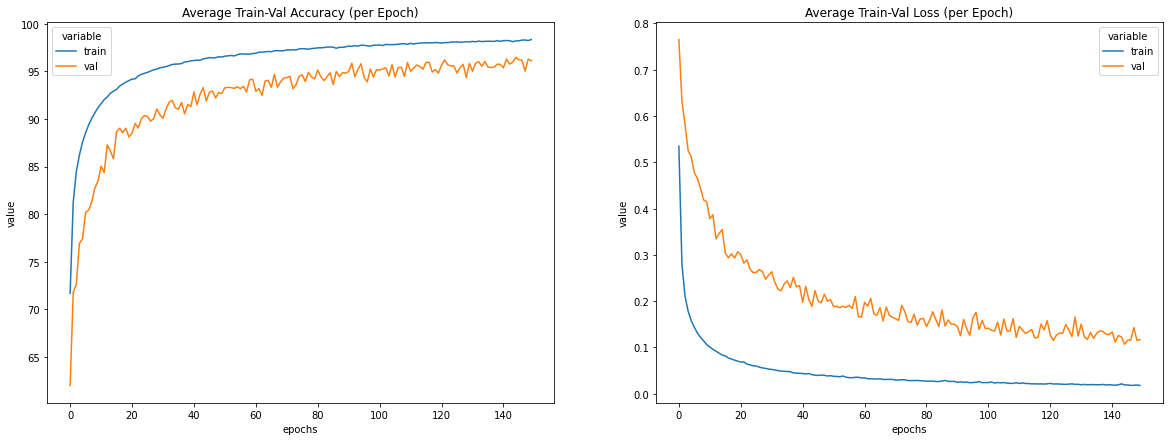

In [16]:
# ===========================================================
# ====== Visualize loss and accuracy for train and val ======
# ===========================================================
# Get mean accuracy
avg_accuracy_train = [np.mean([d['train'][idx] for d in model_stats_full['epoch_acc']]) for idx in range(len(model_stats_full['epoch_acc'][0]['train']))]
avg_accuracy_val = [np.mean([d['val'][idx] for d in model_stats_full['epoch_acc']]) for idx in range(len(model_stats_full['epoch_acc'][0]['val']))]
accuracy_stats_full = {"train": avg_accuracy_train,
                       "val": avg_accuracy_val}

# Get mean loss
avg_loss_train = [np.mean([d['train'][idx] for d in model_stats_full['epoch_loss']]) for idx in range(len(model_stats_full['epoch_loss'][0]['train']))]
avg_loss_val = [np.mean([d['val'][idx] for d in model_stats_full['epoch_loss']]) for idx in range(len(model_stats_full['epoch_loss'][0]['val']))]
loss_stats_full = {"train": avg_loss_train,
                   "val": avg_loss_val}

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_full).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_full).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Average Train-Val Accuracy (per Epoch)')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Average Train-Val Loss (per Epoch)')

In [17]:
# =======================================================
# === Show additional metrics (precision, recall, F1) ===
# =======================================================
print(f"Average accuracy: {np.mean(np.array(model_stats_full['test_acc'])) * 100:.2f}%")

avg_test_precision = np.mean(np.stack(model_stats_full['test_precision']), axis=0) * 100
avg_test_recall = np.mean(np.stack(model_stats_full['test_recall']), axis=0) * 100
avg_test_f1 = np.mean(np.stack(model_stats_full['test_f1']), axis=0) * 100

test_metrics_df_full = pd.DataFrame()
test_metrics_df_full['Label'] = labels_full
test_metrics_df_full['Precision'] = avg_test_precision
test_metrics_df_full['Precision'] = avg_test_precision
test_metrics_df_full['Recall'] = avg_test_recall
test_metrics_df_full['F1-score'] = avg_test_f1
test_metrics_df_full = test_metrics_df_full.round(decimals=2)

test_metrics_df_full

Average accuracy: 66.82%


,Label,Precision,Recall,F1-score
0,Non-level walking,49.06,71.28,57.20
1,Walking,81.30,55.54,65.12
2,Running,75.12,86.83,78.97
3,Standing,77.41,62.00,68.46
4,Lying,88.55,90.57,89.18
5,Sitting,71.81,78.92,73.76


<AxesSubplot:>

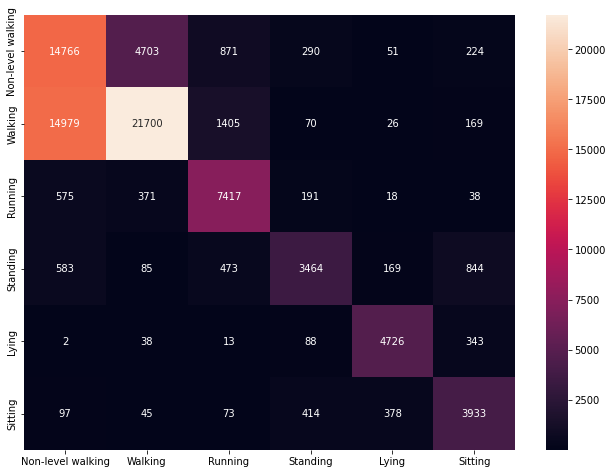

In [18]:
# =======================================================
# ======== Visualize confusion matrix (averaged) ========
# =======================================================
avg_conf_mat = np.sum(np.array(model_stats_full['conf_mat']), axis=0).astype(np.int32)
confusion_matrix_df = pd.DataFrame(avg_conf_mat).rename(columns=idx2class, index=idx2class)

a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")